# Libraries import & setup

In [8]:
!pip install diffusers accelerate transformers safetensors --quiet

In [9]:
!pip install -U peft --quiet

In [10]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionImg2ImgPipeline
from huggingface_hub import InferenceClient, hf_hub_download, login
from IPython.display import display
from PIL import Image
import torch
import ast
import re

In [ ]:
login(token="")

# Step 1: Producing consistent frames via Mistral

In [ ]:
client = InferenceClient(
    provider="hf-inference",
    api_key="",
)

def generate_animation_frames(prompt, steps=5):
    system_message = (
        f"You are an animation assistant to help create ghibli-themed animation frames. "
        f"**Each frame must include the word 'ghibli' or describe the frame as 'ghibli-style'.** "
        f"Break the given ghibli-themed idea into a smooth {steps}-step animation, keeping each frame very simple. "
        f"Do not stray from the given ghibli idea, simple break it into frames that I can use to create a smooth and consistent ghibli animation. "
        f"Each frame must describe only the current ghibli scene, and it must be a simple description. "
        f"Return the result as a **Python list of {steps} strings**, where each string describes a single still frame. "
        f"Do NOT include any titles, explanations, code, formatting, or object coordinates — only a plain list of strings."
        f"Here is an example:\n['A ghibli-themed boy opens a door.', 'He steps into a ghibli glowing forest.', ...]"
    )

    completion = client.chat.completions.create(
        model="mistralai/Mistral-7B-Instruct-v0.3",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt}
        ]
    )

    return completion.choices[0].message.content

In [35]:
def normalize_llm_frame_output(raw_output, steps=5):
    # Try parsing as a Python list (only if it starts and ends with brackets)
    if raw_output.strip().startswith("[") and raw_output.strip().endswith("]"):
        try:
            parsed = ast.literal_eval(raw_output)
            if isinstance(parsed, list) and all(isinstance(item, str) for item in parsed):
                return parsed[:steps]
        except Exception:
            pass

    # Fallback 1: Numbered lines like 1. "..."
    pattern = re.compile(r'\d+\s*[\.\)]\s*["“]?(.*?)["”]?(?=\n\d+|\Z)', re.DOTALL)
    matches = pattern.findall(raw_output)

    # Fallback 2: Bullet points or stray quoted lines
    if not matches:
        matches = re.findall(r'["“”\']([^"\n]+)["“”\']', raw_output)

    # Fallback 3: Rough line-by-line fallback if nothing matches
    if not matches:
        matches = [line.strip("-• \n") for line in raw_output.splitlines() if len(line.strip()) > 3]

    # Clean up stray characters
    cleaned = []
    for m in matches[:steps]:
        m = m.replace("‘", "").replace("’", "'").replace("“", "").replace("”", "").strip()
        cleaned.append(m)

    return cleaned

---
# Step 2: text-to-image for first frame

In [ ]:
base_model = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(base_model, safety_checker=None, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

In [61]:
lora_repo = "ibrahim7004/ghibli-stableDiff-finetuned"
lora_filename = "pytorch_lora_weights.safetensors"

lora_path = hf_hub_download(repo_id=lora_repo, filename=lora_filename)
pipe.unet.load_attn_procs(lora_path)

In [58]:
def save_img(image):
  image_path = "/content/initial_output.png"
  image.save(image_path)

  init_image = Image.open(image_path).convert("RGB")
  init_image = init_image.resize((512, 512))

  return init_image

----
# Step 3: img2img for remaining frames

In [62]:
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    safety_checker=None,
    torch_dtype=torch.float16
).to("cuda")

img2img_pipe.unet.load_attn_procs(lora_path)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


---

In [71]:
def generate_frames(frames):
    for idx, frame in enumerate(frames):
        if idx == 0:
            # Generate first frame using text-to-image pipeline
            image = pipe(frame, num_inference_steps=30).images[0]
            saved_image = save_img(image)
            display(image)
        else:
            # Use img2img for subsequent frames
            refined = img2img_pipe(
                prompt=frame,
                image=saved_image,
                strength=0.7,
                guidance_scale=9.0,
                num_inference_steps=40
            ).images[0]
            display(refined)
            saved_image = save_img(refined)

# Main

In [67]:
result = generate_animation_frames(input("Enter an animation sequence."))
print(result)
frames = normalize_llm_frame_output(result, steps=5)
print(frames)

Enter an animation sequence.ghibli-themed forest setting where a boy climbs a tree
['A young boy stands at the edge of a ghibli-style forest.',
'The boy begins to climb a tall tree in the ghibli forest.',
'Halfway up, he reaches a branch with a view of the sprawling ghibli forest below.',
'From high up, the boy sees various whimsical creatures moving around the ghibli forest.',
'Finally, he finds a cozy nest at the top of the tree, surrounded by ghibli leaves and stars above.']
['A young boy stands at the edge of a ghibli-style forest.', 'The boy begins to climb a tall tree in the ghibli forest.', 'Halfway up, he reaches a branch with a view of the sprawling ghibli forest below.', 'From high up, the boy sees various whimsical creatures moving around the ghibli forest.', 'Finally, he finds a cozy nest at the top of the tree, surrounded by ghibli leaves and stars above.']


  0%|          | 0/30 [00:00<?, ?it/s]

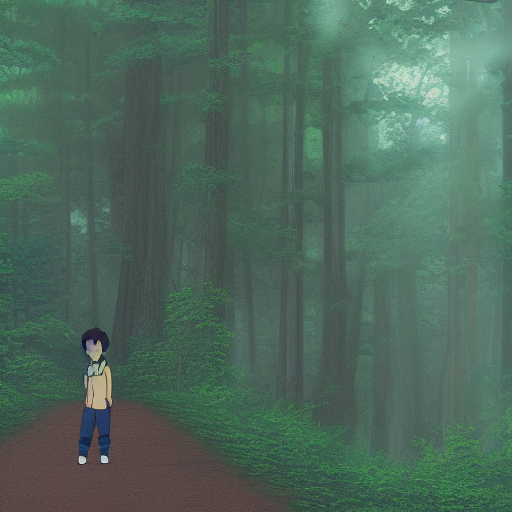

  0%|          | 0/32 [00:00<?, ?it/s]

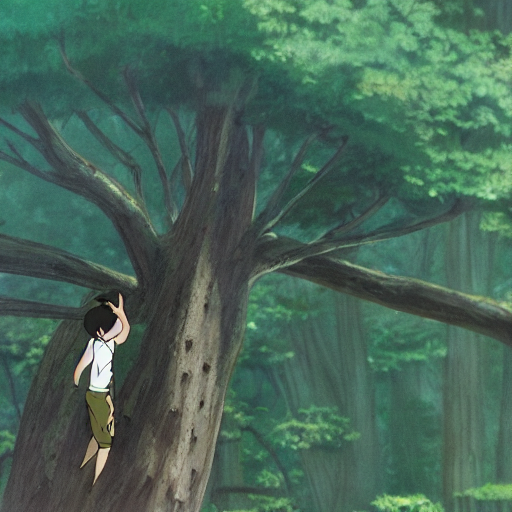

  0%|          | 0/32 [00:00<?, ?it/s]

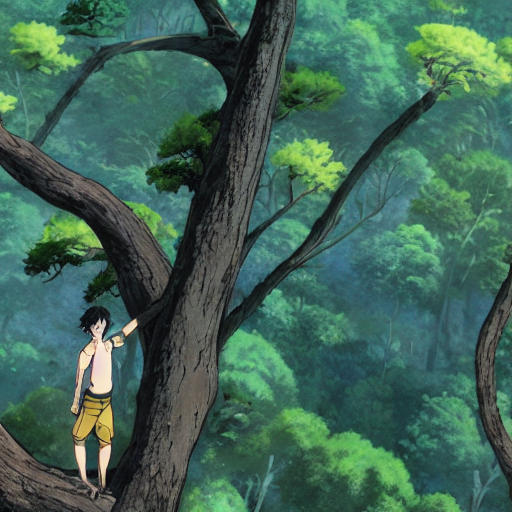

  0%|          | 0/32 [00:00<?, ?it/s]

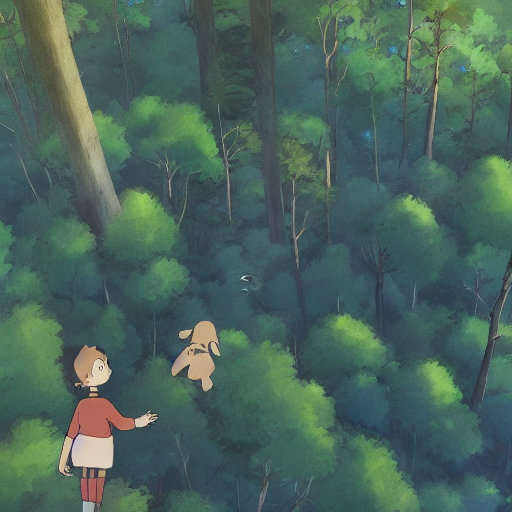

  0%|          | 0/32 [00:00<?, ?it/s]

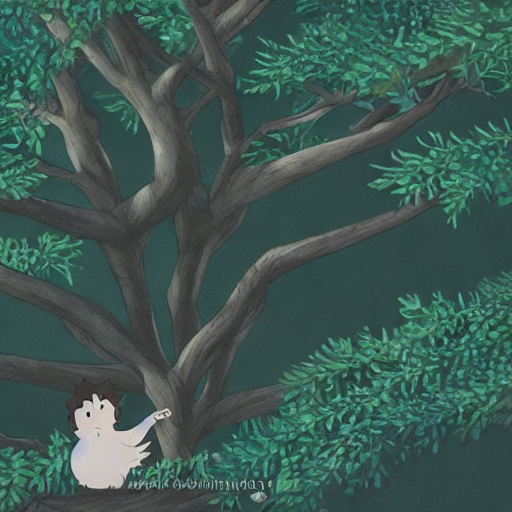

In [72]:
generate_frames(frames)

---